In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline

In [181]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

········


In [200]:
query = \
"""
SELECT de.icustay_id
  , round((EXTRACT(EPOCH FROM (de.charttime-ie.intime))/60.0/60.0) :: NUMERIC, 4) as HOURS
  , di.label
  , de.value
  , de.valuenum
FROM chartevents de
INNER join d_items di
ON de.itemid = di.itemid
INNER join icustays ie
ON de.icustay_id = ie.icustay_id
WHERE de.icustay_id = 252522
ORDER BY charttime;
"""

ce = pd.read_sql_query(query,con)
ce.head()

,icustay_id,hours,label,value,valuenum
0,252522,-0.0128,Patient Location,CC6D,NaN
1,252522,-0.0128,Religion,Unknown,15.0
2,252522,-0.0128,Marital Status,Widowed,4.0
3,252522,0.5372,Heart Rate,90,90.0
4,252522,0.5372,Non Invasive Blood Pressure mean,74,74.0


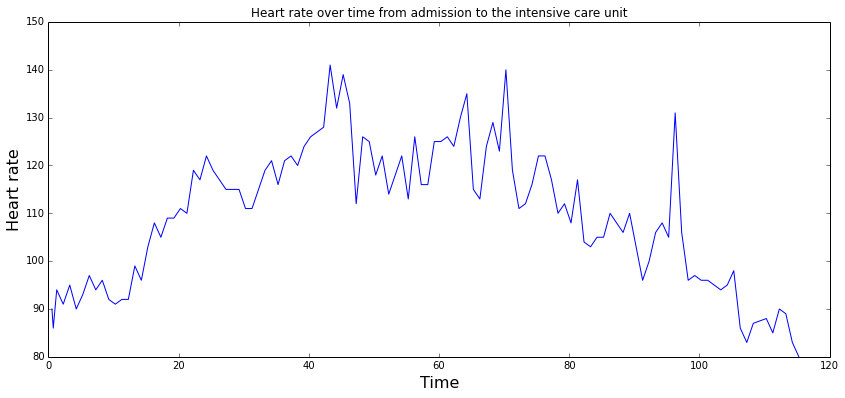

In [201]:
# Set x equal to the times
x_hr = ce.hours[ce.label=='Heart Rate']

# Set y equal to the heart rates
y_hr = ce.valuenum[ce.label=='Heart Rate']

# Plot time against heart rate
plt.figure(figsize=(14, 6))
plt.plot(x_hr,y_hr)


plt.xlabel('Time',fontsize=16)
plt.ylabel('Heart rate',fontsize=16)
plt.title('Heart rate over time from admission to the intensive care unit')

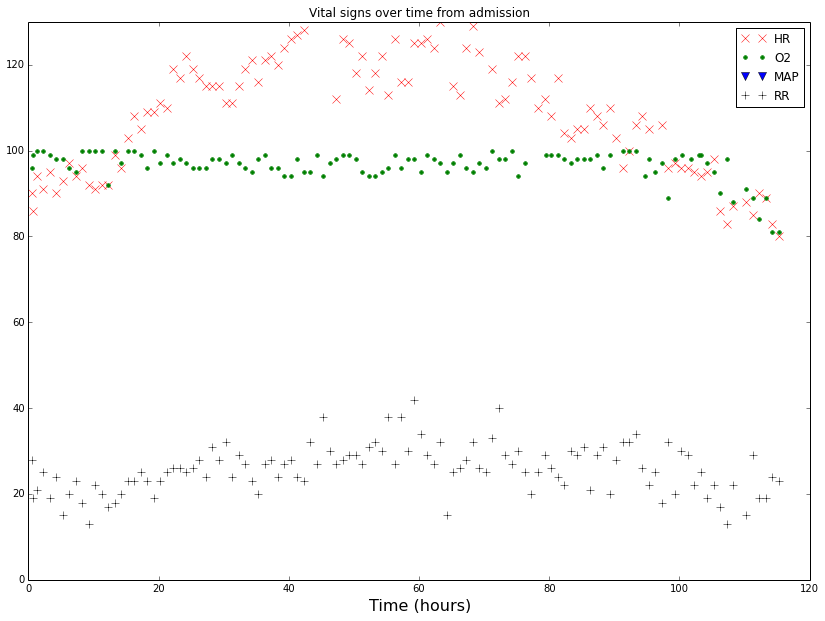

In [202]:
plt.figure(figsize=(14, 10))

plt.plot(ce.hours[ce.label=='Heart Rate'], 
         ce.valuenum[ce.label=='Heart Rate'],
         'rx', markersize=8, label='HR')

plt.plot(ce.hours[ce.label=='O2 saturation pulseoxymetry'], 
         ce.valuenum[ce.label=='O2 saturation pulseoxymetry'], 
         'g.', markersize=8, label='O2')

plt.plot(ce.hours[ce.label=='Arterial Blood Pressure mean'], 
         ce.valuenum[ce.label=='Arterial Blood Pressure mean'], 
         'bv', markersize=8, label='MAP')

plt.plot(ce.hours[ce.label=='Respiratory Rate'], 
         ce.valuenum[ce.label=='Respiratory Rate'], 
         'k+', markersize=8, label='RR')

plt.title('Vital signs over time from admission')
plt.xlabel('Time (hours)',fontsize=16)
plt.ylim(0,130)
plt.legend()


In [63]:
query = \
"""
WITH pvt AS (
  SELECT ie.subject_id, ie.hadm_id, ie.outtime, ie.icustay_id, le.charttime, ad.deathtime
  , CASE when ad.deathtime between ie.intime and ie.outtime THEN 1 ELSE 0 END AS mort_icu
  , CASE when ad.deathtime between ad.admittime and ad.dischtime THEN 1 ELSE 0 END AS mort_hosp
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        when le.itemid = 50868 then 'ANION GAP'
      ELSE null
      END AS label
  , -- add in some sanity checks on the values
    -- the where clause below requires all valuenum to be > 0, 
    -- so these are only upper limit checks
    CASE
      when le.itemid = 50868 and le.valuenum > 10000 then null -- mEq/L 'ANION GAP'

    ELSE le.valuenum
    END AS valuenum
  FROM icustays ie

  LEFT JOIN labevents le
    ON le.subject_id = ie.subject_id 
    AND le.hadm_id = ie.hadm_id
    AND le.charttime between (ie.intime - interval '6' hour) 
    AND (ie.intime + interval '1' day)
    AND le.itemid IN
    (
      -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
      50868 -- ANION GAP | CHEMISTRY | BLOOD | 769895
    )
    AND le.valuenum IS NOT null 
    AND le.valuenum > 0 -- lab values cannot be 0 and cannot be negative
    
    LEFT JOIN admissions ad
    ON ie.subject_id = ad.subject_id
    AND ie.hadm_id = ad.hadm_id
    
    -- WHERE ie.subject_id < 10000
    
),
ranked AS (
SELECT pvt.*, DENSE_RANK() OVER (PARTITION BY 
    pvt.subject_id, pvt.hadm_id,pvt.icustay_id,pvt.label ORDER BY pvt.charttime) as drank
FROM pvt
)
SELECT r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp
  , max(case when label = 'ANION GAP' then valuenum else null end) as ANIONGAP_1st


FROM ranked r
WHERE r.drank = 1
GROUP BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank
ORDER BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank;
"""

data = pd.read_sql_query(query,con)
data.head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,aniongap_1st
0,2,163353,243653,0,0,NaN
1,3,145834,211552,0,0,17.0
2,4,185777,294638,0,0,15.0
3,5,178980,214757,0,0,NaN
4,6,107064,228232,0,0,23.0


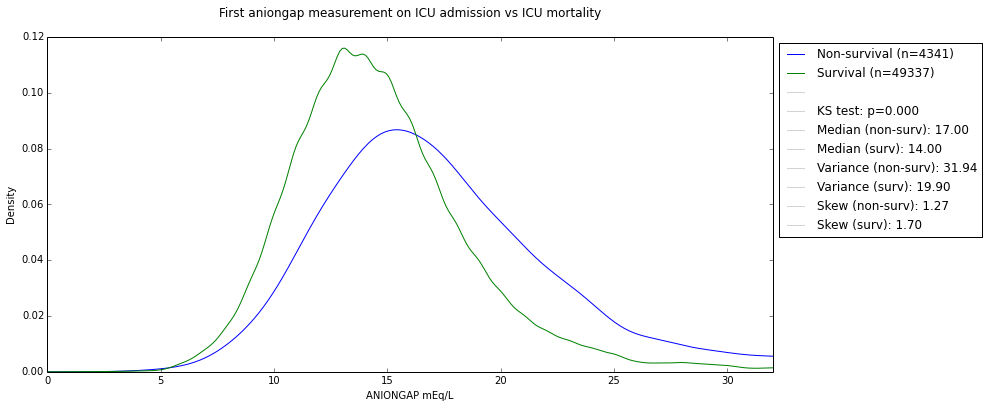

In [30]:
from scipy.stats import ks_2samp


# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_1st'][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_1st'].quantile(0.99))

In [122]:
query = \
"""
SET search_path to mimiciii;

WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id, first_careunit
, icu.los as icu_los
, round((EXTRACT(EPOCH FROM (adm.dischtime-adm.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los
, EXTRACT('epoch' from icu.intime - pat.dob) / 60.0 / 60.0 / 24.0 / 365.242 as age_icu_in
, pat.gender
, RANK() OVER (PARTITION BY icu.subject_id ORDER BY icu.intime) AS icustay_id_order
, hospital_expire_flag
, CASE WHEN pat.dod IS NOT NULL 
       AND pat.dod >= icu.intime - interval '6 hour'
       AND pat.dod <= icu.outtime + interval '6 hour' THEN 1 
       ELSE 0 END AS icu_expire_flag
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
INNER JOIN admissions adm
ON adm.hadm_id = icu.hadm_id    
)

, excl AS
(
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_los, co.hosp_los
  , co.age_icu_in
  , co.gender
  , co.icustay_id_order
  , co.first_careunit
  , co.hospital_expire_flag
  , co.icu_expire_flag
  , CASE
        WHEN co.icu_los < 1 then 1
    ELSE 0 END
    AS exclusion_los
  , CASE
        WHEN co.age_icu_in < 16 then 1
    ELSE 0 END
    AS exclusion_age
  , CASE 
        WHEN co.icustay_id_order != 1 THEN 1
    ELSE 0 END 
    AS exclusion_first_stay
FROM co
)

SELECT vitals.subject_id, vitals.hadm_id, vitals.icustay_id
, heartrate_min, heartrate_max, heartrate_mean
, resprate_min, resprate_max, resprate_mean

--, sysbp_min, sysbp_max, sysbp_mean
--, diasbp_min, diasbp_max, diasbp_mean
--, meanbp_min, meanbp_max, meanbp_mean
--, tempc_min, tempc_max, tempc_mean
--, spo2_min, spo2_max, spo2_mean
--, glucose_min, glucose_max, glucose_mean

FROM excl
INNER JOIN mimiciii_dev.vitalsfirstday vitals
ON vitals.icustay_id = excl.icustay_id
WHERE exclusion_first_stay = 0
AND exclusion_age = 0
AND exclusion_los = 0;
"""

query_output = pd.read_sql_query(query,con)
query_output.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,resprate_min,resprate_max,resprate_mean
0,3,145834,211552,75.0,168.0,111.785714,5.0,24.0,17.361111
1,4,185777,294638,74.0,111.0,89.217391,18.0,32.0,25.352941
2,6,107064,228232,76.0,100.0,84.160000,8.0,20.0,12.320000
3,9,150750,220597,82.0,111.0,92.500000,14.0,19.0,14.369565
4,11,194540,229441,70.0,101.0,84.958333,14.0,23.0,18.045455


In [123]:
len(query_output.dropna())

32188